In [1]:
import numpy as np
import pandas as pd

from Datasets.utk_face import UTKFaceDataset

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

import copy

[0.008620689623057842, 0.0, 0.0, 1.2432509188808893e-10] [1.0, 1.0, 1.0, 0.9900000095367432]


In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 300

# Number of epochs of increasing validation loss to wait before early stopping
patience = 15

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataloader
dataloader = torch.utils.data.DataLoader(UTKFaceDataset(), batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

torch.Size([16, 3, 200, 200])


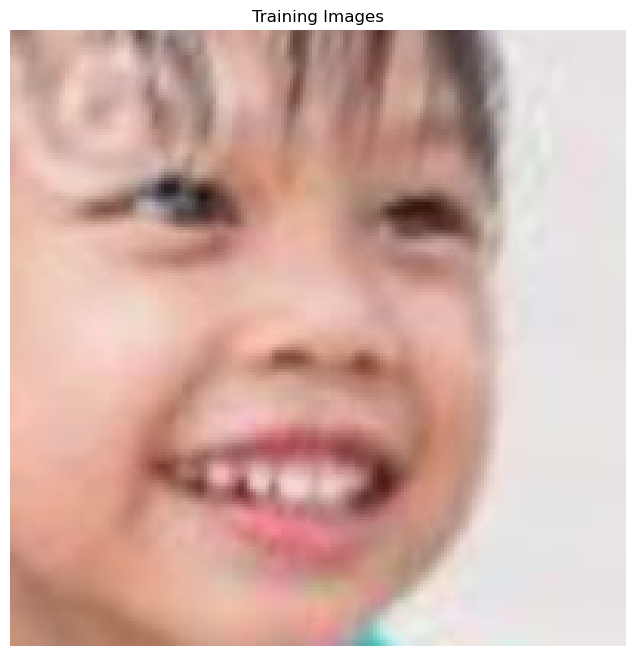

In [4]:
# Plot some training images
images, label = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(images.shape)
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

In [5]:
layers = [
    nn.Conv2d(3, 16, 6, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(16, 8, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, 4, stride=2),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.LazyLinear(1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
]

scorer = nn.Sequential(*layers).to(device)

/opt/homebrew/anaconda3/envs/VAE/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
num_features = 1

layers = [
    nn.Linear(1024 - num_features, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
]

separator = nn.Sequential(*layers).to(device)

In [7]:
z = 1024
layers = [
    nn.Conv2d(3, 16, 6, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(16, 8, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, 4, stride=2),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.LazyLinear(z),
    nn.ReLU(),
    nn.Linear(z, z)
]

from Models.vae import Autoencoder
model = Autoencoder(layers).to(device)

In [8]:
def BPR_loss(images_score, recon_score):
    return (torch.mean(torch.sign(images_score - recon_score)) + 1) / 2

In [9]:
def score_loss(images_score, recon_score):
    return nn.functional.mse_loss(images_score, recon_score)

In [10]:
def recon_loss(images, recon):
    return nn.functional.mse_loss(images, recon)

In [11]:
best_model, best_loss = None, np.inf
epochs_waited = 0

score_criterion = BPR_loss

optimizer = optim.Adam(model.parameters(), lr=lr)
score_optimizer = optim.Adam(scorer.parameters(), lr=lr)
separator_optimizaer = optim.Adam(separator.parameters(), lr=lr*5)
history = []

def step():
    images, labels = next(data_iter)

    images = images.to(device)
    labels = labels.to(device)

    encoding = model.encoder(images)

    features, hidden_features = encoding[:,:num_features], encoding[:,num_features:]
    m_features_loss = nn.functional.mse_loss(labels[:,:num_features], features)

    features_recon = separator(hidden_features.detach())
    separator_loss = nn.functional.mse_loss(features.detach(), features_recon)

    features_recon = separator(hidden_features)
    m_separation_loss = torch.exp( -nn.functional.mse_loss(features, features_recon) )

    recon = model.decoder(encoding)

    images_score, recon_score = scorer(images.detach()), scorer(recon.detach())

    m_recon_loss = recon_loss(images, recon)
    m_score_loss = score_loss(images_score.detach(), recon_score.detach())

    loss = m_recon_loss + m_score_loss + 0.2 * m_features_loss + 0.2 * m_separation_loss

    scorer_loss = score_criterion(images_score, recon_score)

    return loss, scorer_loss, separator_loss, (m_recon_loss, m_score_loss, m_features_loss, m_separation_loss)

train_batches = 100
valid_batches = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):

        optimizer.zero_grad()
        score_optimizer.zero_grad()

        loss, scorer_loss, separator_loss, m_loss = step()

        loss.backward()
        optimizer.step()
        
        scorer_loss.backward()
        score_optimizer.step()

        separator_loss.backward()
        separator_optimizaer.step()

        total_train_loss += m_loss[0].item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Epoch:", epoch+1)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        loss, scorer_loss, separator_loss, m_loss = step()

        total_valid_loss += m_loss[0].item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    epochs_waited += 1
    if (valid_loss < best_loss):
        best_loss = valid_loss
        best_model = Autoencoder(layers)
        best_model.load_state_dict(model.state_dict())
        epochs_waited = 0

    if (epochs_waited > patience):
        break

    history.append((train_loss, valid_loss))

model = best_model
    

Epoch: 1
Train loss: 0.19004270229488612
Valid loss: 0.056748113967478274
Epoch: 2
Train loss: 0.05300717368721962
Valid loss: 0.049176087230443956
Epoch: 3
Train loss: 0.04566182587295771
Valid loss: 0.043264968506991866
Epoch: 4
Train loss: 0.04348659794777632
Valid loss: 0.043898988701403144
Epoch: 5
Train loss: 0.041307902690023185
Valid loss: 0.042489790357649326
Epoch: 6
Train loss: 0.04042271833866835
Valid loss: 0.041257434710860255
Epoch: 7
Train loss: 0.04002644227817655
Valid loss: 0.03977341093122959
Epoch: 8
Train loss: 0.039221577048301696
Valid loss: 0.03770723193883896
Epoch: 9
Train loss: 0.03591967225074768
Valid loss: 0.034047916904091834
Epoch: 10
Train loss: 0.03279262920841575
Valid loss: 0.03196631586179137
Epoch: 11
Train loss: 0.03103675777092576
Valid loss: 0.028604865353554488
Epoch: 12
Train loss: 0.027681726645678282
Valid loss: 0.026855950616300105
Epoch: 13
Train loss: 0.025821838695555925
Valid loss: 0.026403539814054966
Epoch: 14
Train loss: 0.025369469

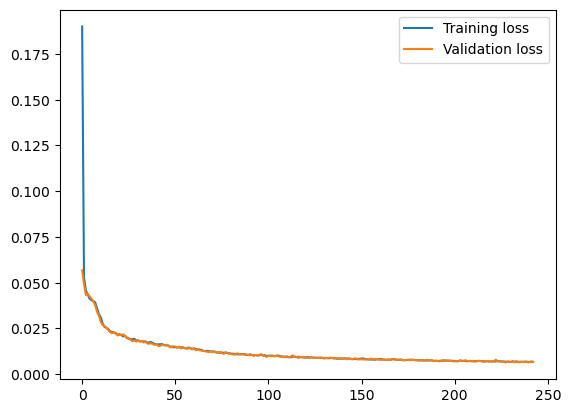

In [12]:
plt.plot(history)
plt.legend(["Training loss", "Validation loss"])
plt.show()

In [13]:
# test set image
images, labels = next(data_iter)

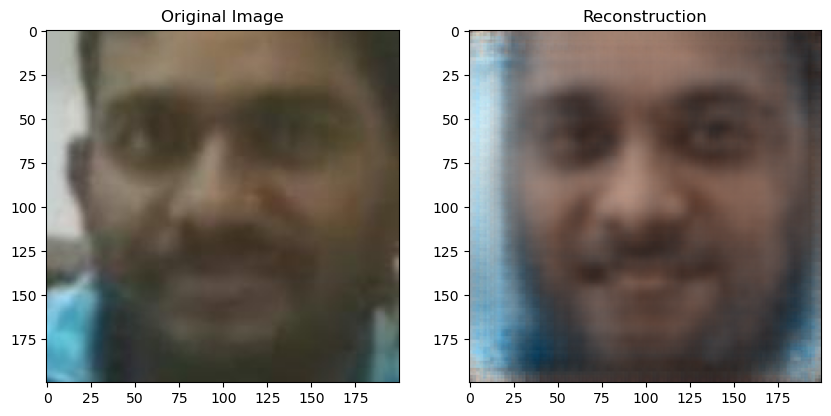

Teacherless recon


In [14]:
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    recon = model(images.to(device))

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

print("Teacherless recon")

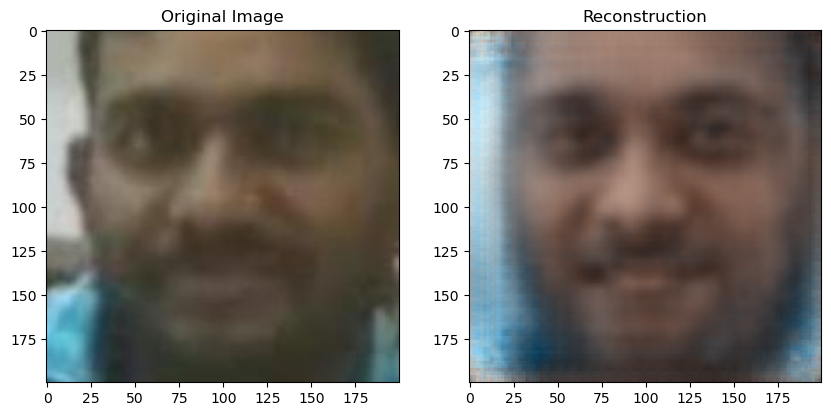

True labels: tensor([0.2241])


In [15]:
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    encoding = model.encoder(images.to(device))

    encoding[0,:num_features] = labels[0,:num_features]
    recon = model.decoder(encoding)

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

print("True labels:", labels[0,:num_features])

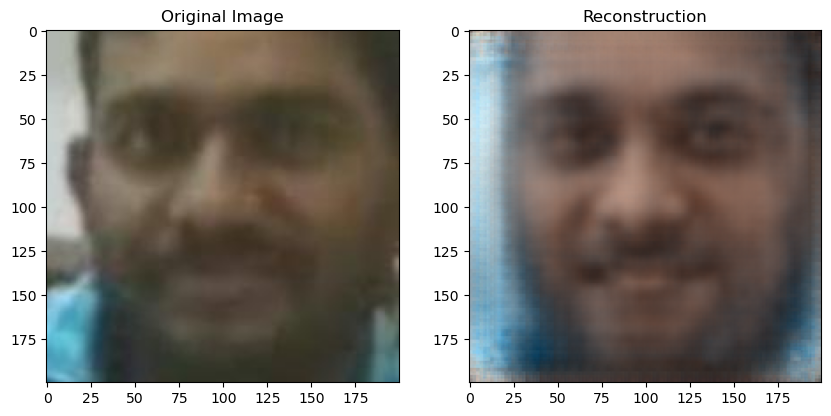

Picked labels tensor([0.0862], device='mps:0')


In [16]:
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    encoding = model.encoder(images.to(device))

    encoding[0,0] = 10 / 116
    recon = model.decoder(encoding)

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

print("Picked labels", encoding[0,:num_features])

In [17]:
print(labels[0,:num_features], separator(encoding[:,num_features:]), encoding[0,:num_features])

tensor([0.2241]) tensor([[0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198],
        [0.6198]], device='mps:0', grad_fn=<LinearBackward0>) tensor([0.0862], device='mps:0')


In [18]:
best_loss = np.inf
epochs_waited = 0

score_criterion = BPR_loss

history = []

def step():
    images, labels = next(data_iter)

    images = images.to(device)
    labels = labels.to(device)

    encoding = model.encoder(images)

    features, hidden_features = encoding[:,:num_features], encoding[:,num_features:]
    m_features_loss = nn.functional.mse_loss(labels[:,:num_features], features)

    features_recon = separator(hidden_features.detach())
    separator_loss = nn.functional.mse_loss(features.detach(), features_recon)

    features_recon = separator(hidden_features)
    m_separation_loss = torch.exp( -nn.functional.mse_loss(features, features_recon) )

    recon = model.decoder(encoding)

    images_score, recon_score = scorer(images.detach()), scorer(recon.detach())

    m_recon_loss = recon_loss(images, recon)
    m_score_loss = score_loss(images_score.detach(), recon_score.detach())

    loss = m_recon_loss + m_score_loss + 0.2 * m_features_loss + 0.2 * m_separation_loss

    scorer_loss = score_criterion(images_score, recon_score)

    return loss, scorer_loss, separator_loss, (m_recon_loss, m_score_loss, m_features_loss, m_separation_loss)

train_batches = 100
valid_batches = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):

        optimizer.zero_grad()
        score_optimizer.zero_grad()

        loss, scorer_loss, separator_loss, m_loss = step()

        separator_loss.backward()
        separator_optimizaer.step()

        total_train_loss += separator_loss.item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Epoch:", epoch+1)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        loss, scorer_loss, separator_loss, m_loss = step()

        total_valid_loss += separator_loss.item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    epochs_waited += 1
    if (valid_loss < best_loss):
        best_loss = valid_loss
        # best_model = Autoencoder(layers)
        # best_model.load_state_dict(model.state_dict())
        epochs_waited = 0

    if (epochs_waited > patience):
        break

    history.append((train_loss, valid_loss))

# model = best_model
    

Epoch: 1
Train loss: 0.6200050246715546
Valid loss: 0.6438355475664139
Epoch: 2
Train loss: 0.6660686561465263
Valid loss: 0.6791697084903717
Epoch: 3
Train loss: 0.65123080432415
Valid loss: 0.5865022495388985
Epoch: 4
Train loss: 0.5719698297977448
Valid loss: 0.5613500237464905
Epoch: 5
Train loss: 0.44724912896752356
Valid loss: 0.3820548452436924
Epoch: 6
Train loss: 0.30661554604768754
Valid loss: 0.24749412015080452
Epoch: 7
Train loss: 0.18362513571977615
Valid loss: 0.13948506750166417
Epoch: 8
Train loss: 0.12960639532655477
Valid loss: 0.09345801491290331
Epoch: 9
Train loss: 0.11012888872995973
Valid loss: 0.13282924182713032
Epoch: 10
Train loss: 0.13597496174275875
Valid loss: 0.18388082310557366
Epoch: 11
Train loss: 0.18776792496442796
Valid loss: 0.22034391798079014
Epoch: 12
Train loss: 0.2709697324037552
Valid loss: 0.33153013586997987
Epoch: 13
Train loss: 0.3771995943784714
Valid loss: 0.36226641535758974
Epoch: 14
Train loss: 0.4541624689102173
Valid loss: 0.48762

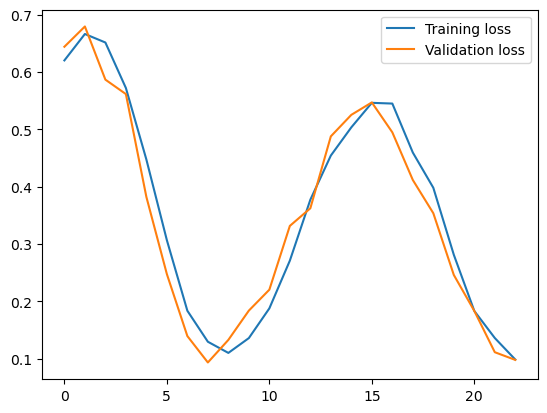

In [19]:
plt.plot(history)
plt.legend(["Training loss", "Validation loss"])
plt.show()